In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

from dotenv import load_dotenv
load_dotenv()
DATASET_PATH="/home/cpsl/Downloads/datasets"
CONFIG_DIRECTORY = "/home/cpsl/Documents/CPSL_ROS2_RadStack/submodules/mmwave_radar_processing/configs"
HERMES_MODEL_STATE_DICT_PATH="/home/cpsl/Documents/CPSL_ROS2_RadStack/src/mmwave_radar_processing/model_state_dicts"
MODEL_TRAINING_DATASET_PATH="/home/cpsl/Downloads/datasets"
GENERATED_DATASETS_PATH="/home/cpsl/Downloads/datasets"

sys.path.append("../")
from mmwave_radar_processing.config_managers.cfgManager import ConfigManager
from cpsl_datasets.cpsl_ds import CpslDS

from mmwave_model_integrator.input_encoders.hermes_encoder import HermesEncoder
from mmwave_model_integrator.ground_truth_encoders.hermes_gt_encoder import HermesGTEncoder
from mmwave_model_integrator.plotting.plotter_hermes import PlotterHermes
from mmwave_model_integrator.dataset_generators.hermes_dataset_generator import HermesDatasetGenerator

from mmwave_model_integrator.model_runner.hermes_runner import HermesRunner
from mmwave_model_integrator.decoders.heremes_decoder import HermesDecoder
from mmwave_model_integrator.plotting.movie_generator_hermes import MovieGeneratorHermes
from mmwave_model_integrator.analyzers.analyzer_hermes import AnalyzerHermes


/home/cpsl/.cache/pypoetry/virtualenvs/cpsl-ros2-radstack-aq5dMwGb-py3.12/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
cfg_manager = ConfigManager()

cfg_path = os.path.join(CONFIG_DIRECTORY,"1843_RadVel_10Hz_lr.cfg")
cfg_manager.load_cfg(cfg_path)
cfg_manager.compute_radar_perforance(profile_idx=0)

In [3]:
#load the dataset
#determine the paths to all of the datasets
dataset_name = "hermes_north_vicon_7"
dataset_path = os.path.join(MODEL_TRAINING_DATASET_PATH,dataset_name)

dataset = CpslDS(
    dataset_path=dataset_path,
    radar_folder="front_radar_adc",
    lidar_folder="lidar",
    camera_folder="camera",
    imu_orientation_folder="imu_data",
    imu_full_folder="imu_data_full",
    vehicle_odom_folder="vehicle_odom"
)

found 852 radar samples
found 852 lidar samples
did not find camera samples
did not find hand tracking samples
did not find imu (orientation) samples
did not find imu (full data) samples
found 852 vehicle velocity samples
found 852 vehicle odometry samples


In [4]:
input_encoder = HermesEncoder(
    config_manager=cfg_manager,
    az_angle_bins_rad=np.deg2rad(np.linspace(
        start=-90,stop=90,num=90
    )),
    num_frames=5,
    stride=1,
    min_vel=np.array([0.00,0.30,0.0]),
    max_vel=np.array([0.1,0.70,0.1]), #np.array([0.05,0.50,0.05]),
    max_vel_stdev=np.array([0.02,0.02,0.02]), #np.array([0.02,0.02,0.02]),
    power_threshold_dB=20
)

ground_truth_encoder = HermesGTEncoder(
    hermes_encoder=input_encoder,
    candidate_points_threshold=0.05,
    valid_points_distance_threshold_m=1.0
)

plotter = PlotterHermes()

input_dimmensions = (64,128)
runner = HermesRunner(
    state_dict_path=os.path.join(HERMES_MODEL_STATE_DICT_PATH,"hermes_mini.pth"),
    cuda_device="cpu",
    input_dimmensions=input_dimmensions,
    encoder_out_channels = (64,128),
    decoder_input_channels = (256,128)
)

prediction_decoder = HermesDecoder(
    input_encoder=input_encoder,
    output_size=np.array(input_dimmensions)
)

movie_generator = MovieGeneratorHermes(
    cpsl_dataset=dataset,
    plotter=plotter,
    input_encoder=input_encoder,
    runner=runner,
    decoder=prediction_decoder,
    ground_truth_encoder=ground_truth_encoder,
    temp_dir_path=os.path.join("/home/cpsl/Downloads/datasets","Hermes")
)

analyzer = AnalyzerHermes(
    cpsl_dataset=dataset,
    input_encoder=input_encoder,
    model_runner=runner,
    prediction_decoder=prediction_decoder,
    ground_truth_encoder=ground_truth_encoder,
    temp_dir_path=os.getenv("ANALYZER_TEMP_DIRECTORY")
)

_ModelRunner: using CPU
Total number of parameters: 1864257
found temp dir: /home/cpsl/Downloads/datasets/Hermes
clearing temp directory /home/cpsl/Downloads/datasets/Hermes


In [5]:
print("x_vals_m:")
print(f"Min: {min(prediction_decoder.x_vals_m)}, Max: {max(prediction_decoder.x_vals_m)}, Resolution: {prediction_decoder.x_vals_m[1] - prediction_decoder.x_vals_m[0]}")

print("y_vals_m:")
print(f"Min: {min(prediction_decoder.y_vals_m)}, Max: {max(prediction_decoder.y_vals_m)}, Resolution: {prediction_decoder.y_vals_m[1] - prediction_decoder.y_vals_m[0]}")

x_vals_m:
Min: 0.0, Max: 12.200000000000001, Resolution: 0.19365079365079366
y_vals_m:
Min: -12.291490778, Max: 12.208509221999915, Resolution: 0.19291338582677042


In [6]:
#go until the encoder is ready
idx = 0
while not input_encoder.full_encoding_ready:

    try: #try accessing the full odometry data
        vel_data = np.mean(dataset.get_vehicle_odom_data(idx)[:,8:11],axis=0)
    except AssertionError: #if not just get the x velocity (forward)
        vel = np.mean(dataset.get_vehicle_vel_data(idx)[:,1])
        vel_data = np.array([vel,0,0])
    
    adc_cube = dataset.get_radar_data(idx)
    
    resp = input_encoder.encode(
        adc_data_cube=adc_cube,
        vels=vel_data
    )
    idx += 1

print(idx)

158


In [7]:
#prime the input encoder for data
sample_idx = idx - 1
# sample_idx = 387
for i in range(sample_idx):
    #get vel_data
    vel_data = np.mean(dataset.get_vehicle_odom_data(i)[:,8:11],axis=0)
    #convert into ned
    ned_vel_data = np.array([
        vel_data[0],
        vel_data[1],
        vel_data[2]
    ])

    #get adc data
    adc_cube = dataset.get_radar_data(i)

    #process the data
    input_encoder.encode(adc_cube,ned_vel_data)

adc_cube = dataset.get_radar_data(sample_idx)
# print(input_encoder.full_encoding_ready)

try: #try accessing the full odometry data
    vel_data = np.mean(dataset.get_vehicle_odom_data(sample_idx)[:,8:11],axis=0)
except AssertionError: #if not just get the x velocity (forward)
    vel = np.mean(dataset.get_vehicle_vel_data(sample_idx)[:,1])
    vel_data = np.array([vel,0,0])

#accessing lidar ground truth output and encoding it
lidar_pc = dataset.get_lidar_point_cloud_raw(idx)

#getting camera data
try:
    camera_view = dataset.get_camera_frame(idx)
except AssertionError:
    camera_view = np.empty(shape=(0))

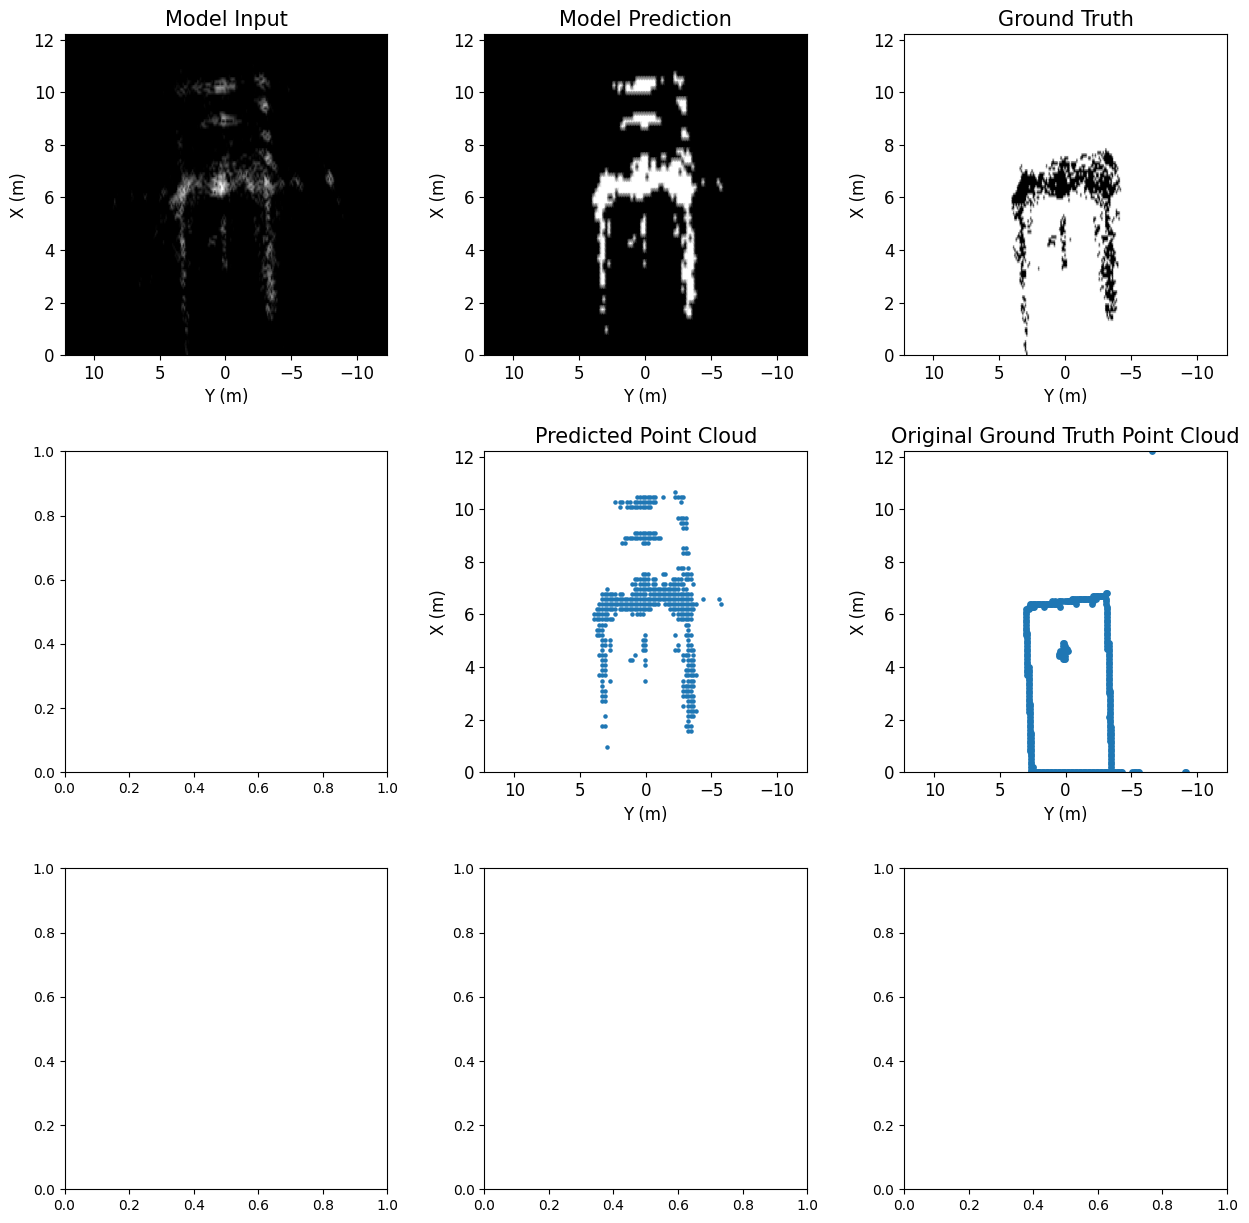

In [8]:
plotter.plot_compilation(
    input_adc_cube=adc_cube,
    input_vels=vel_data,
    input_encoder=input_encoder,
    runner=runner,
    decoder=prediction_decoder,
    gt_data=lidar_pc,
    ground_truth_encoder=ground_truth_encoder,
    camera_view=camera_view,
    axs=[],
    show=True
)

In [9]:
grid = ground_truth_encoder.encode(
    lidar_pc=lidar_pc,
    input_encoding=input_encoder.encoded_data
)
out_pc = ground_truth_encoder.grid_to_points(grid)

(64, 128)


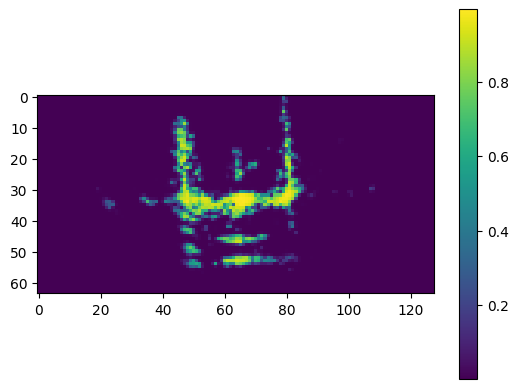

In [10]:
raw_resp_raw = runner.make_prediction_raw(input=input_encoder.encoded_data)
print(raw_resp_raw.shape)
plt.imshow(raw_resp_raw)
plt.colorbar()

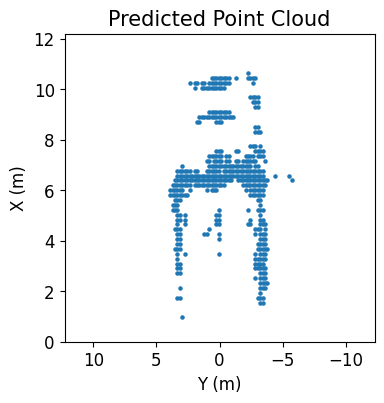

In [11]:
fig,ax = plt.subplots(figsize=(4,4))

pred = runner.make_prediction(input=input_encoder.encoded_data)
pc = prediction_decoder.decode(pred)

plotter.plot_predicted_pc(
    point_cloud=pc,
    hermes_decoder=prediction_decoder,
    ax=ax,
    show=True
)

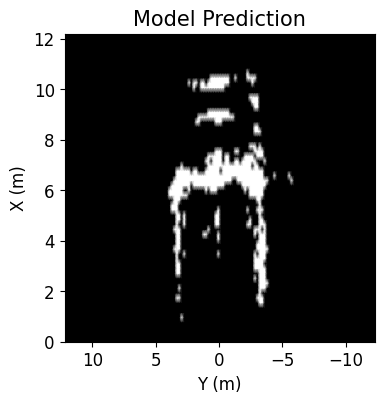

In [12]:
fig,ax = plt.subplots(figsize=(4,4))

plotter.plot_model_prediction(
    pred=pred,
    hermes_decoder=prediction_decoder,
    cmap="gray",
    ax=ax,
    show=False
)

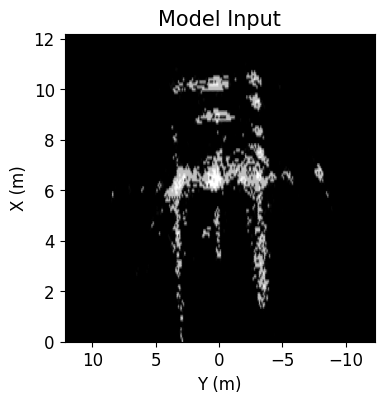

In [13]:
fig,ax = plt.subplots(figsize=(4,4))

input_encoding = input_encoder.encoded_data

high_idx = input_encoding > 0.5
mid_idxs = (input_encoding <= 0.5) & (input_encoding > 0.1)

input_encoding[high_idx] = 1.0
input_encoding[mid_idxs] = 0.75

plotter.plot_input_encoding(
    encoding=input_encoding,
    hermes_encoder=input_encoder,
    cmap="grey",
    ax=ax,
    show=False
)

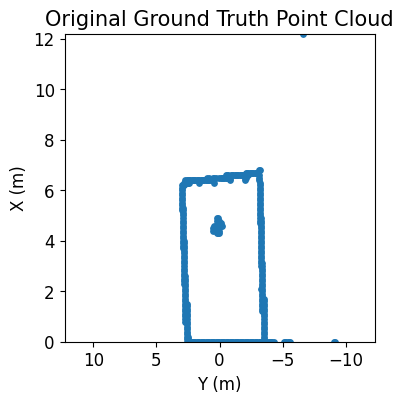

In [14]:
fig,ax = plt.subplots(figsize=(4,4))

original_gt_pc = ground_truth_encoder.grid_to_points(
    ground_truth_encoder.original_gt_encoding)
plotter.plot_gt_pc(
    point_cloud=original_gt_pc,
    gt_encoder=ground_truth_encoder,
    ax=ax,
    title="Original Ground Truth Point Cloud",
    show=False
)

In [15]:
#speed comparison
from tqdm import tqdm

for i in tqdm(range(dataset.num_frames)):

    # adc_cube = dataset.get_radar_data(idx=1)
    # try: #try accessing the full odometry data
    #     vel_data = np.mean(dataset.get_vehicle_odom_data(idx)[:,8:11],axis=0)
    # except AssertionError: #if not just get the x velocity (forward)
    #     vel = np.mean(dataset.get_vehicle_vel_data(idx)[:,1])
    #     vel_data = np.array([vel,0,0])
    # rng_az_resp = input_encoder.encode(adc_cube,vel_data)
    if input_encoder.full_encoding_ready:
        pred = runner.make_prediction(input=input_encoder.encoded_data)
        pc = prediction_decoder.decode(pred)


100%|██████████| 852/852 [01:12<00:00, 11.69it/s]


In [31]:
chamfer,hausdorff, chamfer_radarHD, modified_hausdorff_radarHD = \
    analyzer.compute_all_distance_metrics(
        save_to_file=True,
        file_name=dataset_name
    )
analyzer.show_all_summary_statistics(
    chamfer_distances=chamfer,
    hausdorff_distances=hausdorff,
    chamfer_distances_radarHD=chamfer_radarHD,
    modified_hausdorff_distances_radarHD=modified_hausdorff_radarHD
)

Analyzer.compute_all_distance_metrics: Computing distance metrics


100%|██████████| 694/694 [00:32<00:00, 21.33it/s]

Analyzer.compute_all_distance_metrics: number failed predictoins 0 of 694 (0.0%)


,Metric,Hausdorff,Modified Hausdorff (radarHD),Chamfer,Chamfer (radarHD)
0,Mean,4.765181,0.087879,1.310504,0.309258
1,Median,4.851610,0.088880,1.203505,0.297904
2,90th percentile,6.275602,0.093919,1.804786,0.385356


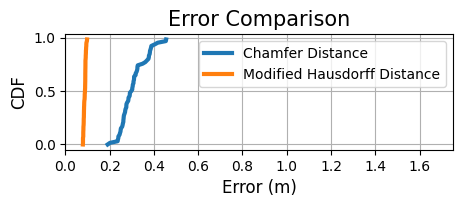

In [32]:
plotter.plot_distance_metrics_cdfs(
    # chamfer_distances=chamfer,
    # hausdorf_distances=hausdorff,
    chamfer_distances_radarHD=chamfer_radarHD,
    modified_hausdorf_distances_radarHD=modified_hausdorff_radarHD
)

100%|██████████| 67/67 [00:06<00:00, 10.22it/s]


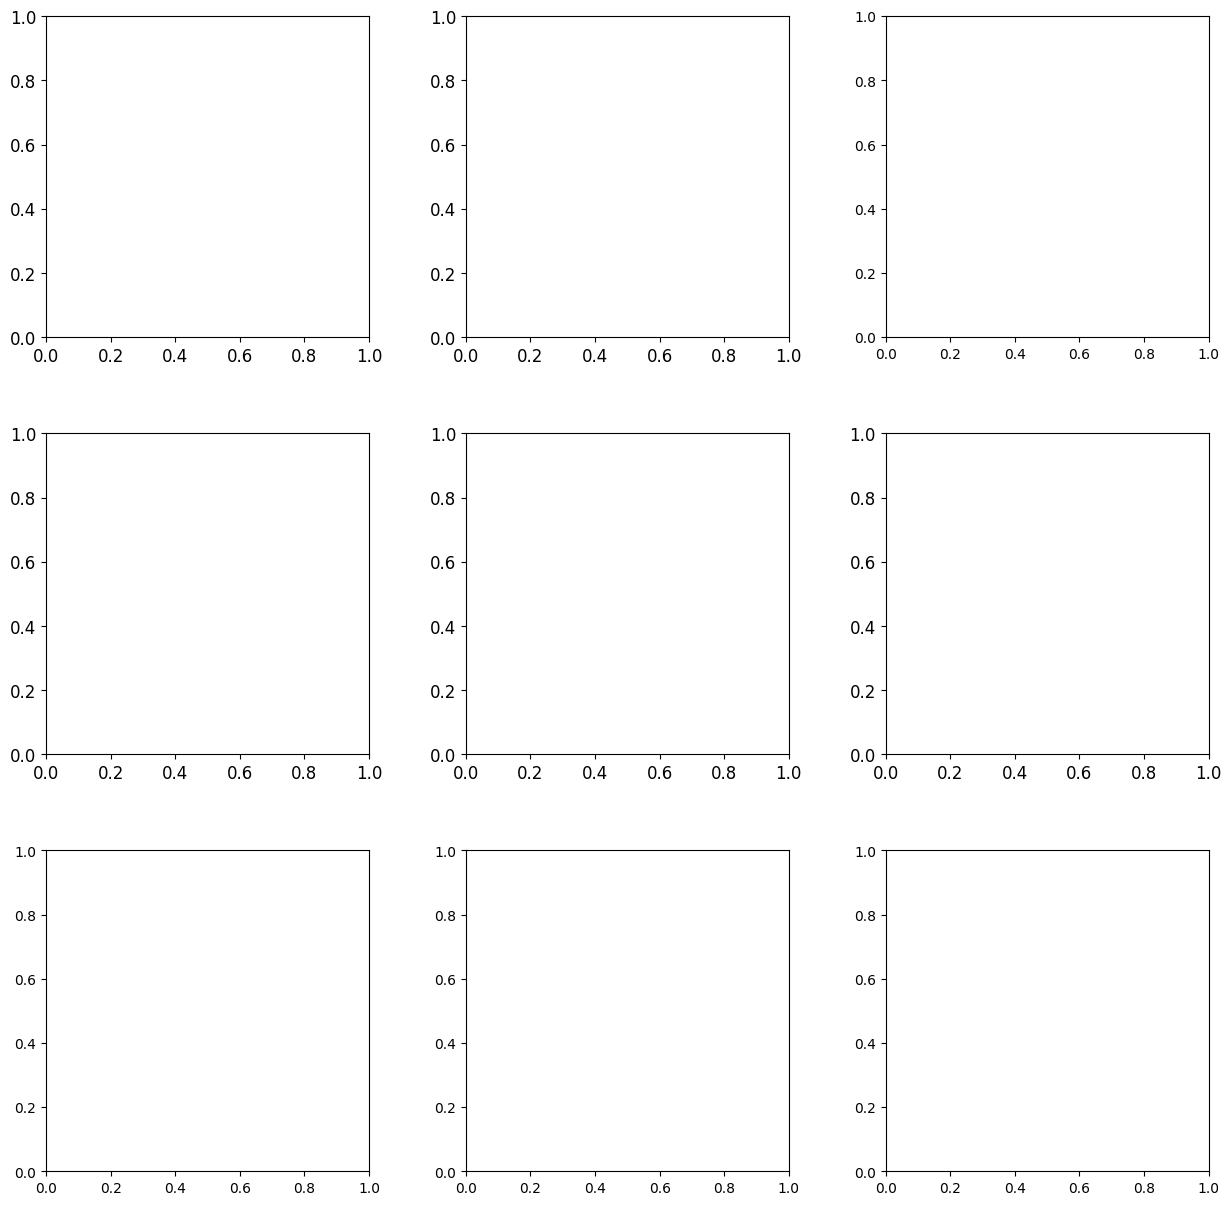

In [26]:
movie_generator.initialize_figure(
    nrows=3,
    ncols=3,
    figsize=(15,15),
    wspace=0.3,
    hspace=0.3
)

movie_generator.generate_movie_frames()

fps = 1 / (1e-3 * cfg_manager.frameCfg_periodicity_ms)
movie_generator.save_movie(video_file_name="{}_revised_mini.mp4".format(dataset_name),fps=fps)